In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 123
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


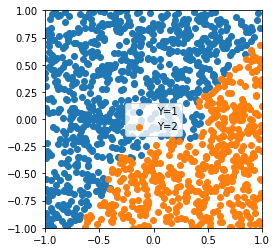

Vizualizing labelset:slice_1:pred from payload_test


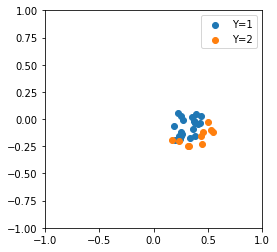

Vizualizing labelset:slice_1:ind from payload_test


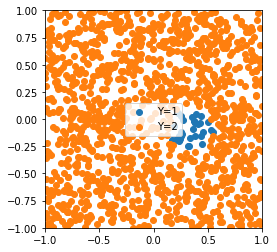

Vizualizing labelset:slice_2:pred from payload_test


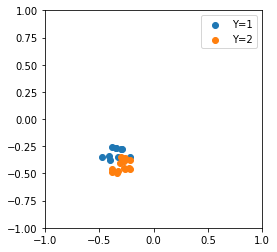

Vizualizing labelset:slice_2:ind from payload_test


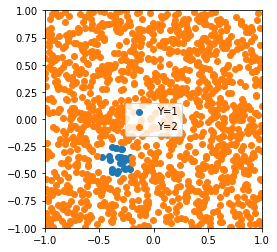

Vizualizing labelset:remainder:pred from payload_test


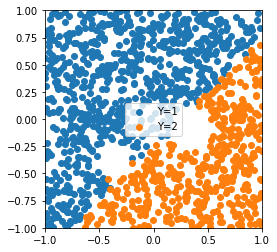

Vizualizing labelset:remainder:ind from payload_test


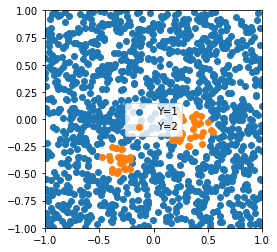

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))

model_configs = {
    'soft_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'model_class': SliceModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        }
    },
    'hard_param': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'model_class': MetalModel,
        'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
    },
    'manual_reweighting': {
        'slice_funcs': all_slice_funcs,
        'create_ind': False,
        'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
        'model_class': MetalModel        
    },
    'moe': {
        'slice_funcs': {},
        'create_ind': False,
        'model_class': MoEModel
    },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 500,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

==========Initializing + Training soft_param==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:pred': 'test_task:slice_2:pred', 'labelset:slice_2:i

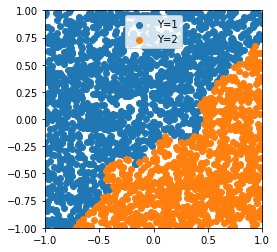

Vizualizing labelset:slice_1:pred from payload_train


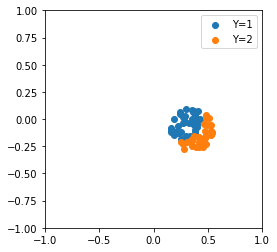

Vizualizing labelset:slice_1:ind from payload_train


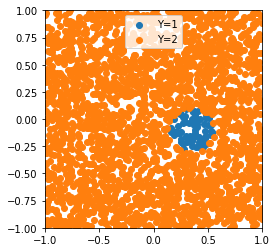

Vizualizing labelset:slice_2:pred from payload_train


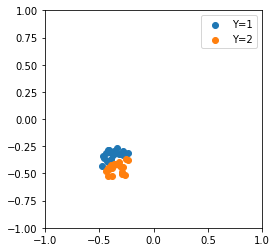

Vizualizing labelset:slice_2:ind from payload_train


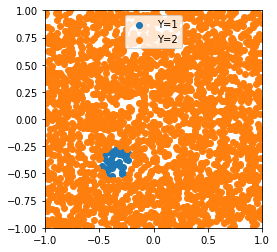

Vizualizing labelset:BASE:pred from payload_train


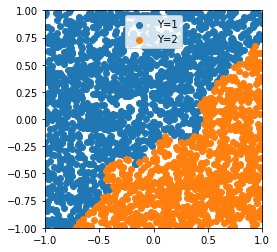

Vizualizing labelset:BASE:ind from payload_train


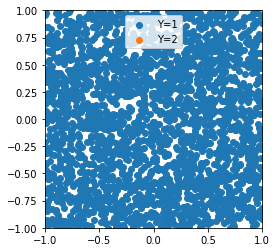

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_30/13_39_08/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.46e-01, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.74e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.10e-02, payload_valid/labelset:slice_2:ind/accuracy=9.90e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=2.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.10e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.39e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelse

[50.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.45e-02, payload_valid/labelset:slice_1:ind/accuracy=9.74e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.68e-03, payload_valid/labelset:slice_2:ind/accuracy=9.90e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.89e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.13e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.33e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=2.53e-02, train/all/lr=1.00e-02, valid/all/loss=2.25e-02]
[55.0 epo]: test_task:[payload_train/labelset_gold/los

[95.0 epo]: test_task:[payload_train/labelset_gold/loss=8.72e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.32e-02, payload_valid/labelset:slice_1:ind/accuracy=9.74e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.90e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.52e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.58e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.15e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.65e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=2.49e-02, train/all/lr=1.00e-02, valid/all/loss=2.23e-02]
[100.0 epo]: test_task:[payload_train/labelset_gold/lo

[140.0 epo]: test_task:[payload_train/labelset_gold/loss=8.70e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.74e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.60e-03, payload_valid/labelset:slice_2:ind/accuracy=9.90e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.52e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.47e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.00e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.49e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=2.40e-02, train/all/lr=1.00e-02, valid/all/loss=2.16e-02]
[145.0 epo]: test_task:[payload_train/labelset_gold/l

[185.0 epo]: test_task:[payload_train/labelset_gold/loss=7.09e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.33e-03, payload_valid/labelset:slice_1:ind/accuracy=9.78e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.63e-03, payload_valid/labelset:slice_2:ind/accuracy=9.91e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.56e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.48e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.80e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.66e-03, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=2.08e-02, train/all/lr=1.00e-02, valid/all/loss=2.14e-02]
[190.0 epo]: test_task:[payload_train/labelset_gold/l

[230.0 epo]: test_task:[payload_train/labelset_gold/loss=6.36e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.11e-03, payload_valid/labelset:slice_2:ind/accuracy=9.91e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.48e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.19e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.86e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.39e-03, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.90e-02, train/all/lr=1.00e-02, valid/all/loss=2.74e-02]
[235.0 epo]: test_task:[payload_train/labelset_gold/l

[275.0 epo]: test_task:[payload_train/labelset_gold/loss=6.55e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.25e-03, payload_valid/labelset:slice_1:ind/accuracy=9.75e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.90e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.97e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.78e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.08e-03, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.92e-02, train/all/lr=1.00e-02, valid/all/loss=3.37e-02]
[280.0 epo]: test_task:[payload_train/labelset_gold/l

[320.0 epo]: test_task:[payload_train/labelset_gold/loss=5.99e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=8.12e-03, payload_valid/labelset:slice_1:ind/accuracy=9.80e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.73e-03, payload_valid/labelset:slice_2:ind/accuracy=9.92e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.42e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.41e-02, payload_valid/labelset:slice_1:pred/accuracy=8.48e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.67e-03, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02, valid/all/loss=1.56e-02]
[325.0 epo]: test_task:[payload_train/labelset_gold/l

[365.0 epo]: test_task:[payload_train/labelset_gold/loss=5.61e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.83e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.30e-03, payload_valid/labelset:slice_2:ind/accuracy=9.94e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.76e-02, payload_valid/labelset:slice_1:pred/accuracy=8.79e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.99e-04, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.60e-02, train/all/lr=1.00e-02, valid/all/loss=1.45e-02]
[370.0 epo]: test_task:[payload_train/labelset_gold/l

[410.0 epo]: test_task:[payload_train/labelset_gold/loss=5.61e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.38e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.92e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.41e-02, payload_valid/labelset:slice_1:pred/accuracy=8.79e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.41e-04, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.55e-02, train/all/lr=1.00e-02, valid/all/loss=1.41e-02]
[415.0 epo]: test_task:[payload_train/labelset_gold/l

[455.0 epo]: test_task:[payload_train/labelset_gold/loss=5.55e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.46e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.86e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.12e-02, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.08e-04, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.50e-02, train/all/lr=1.00e-02, valid/all/loss=1.38e-02]
[460.0 epo]: test_task:[payload_train/labelset_gold/l

[500.0 epo]: test_task:[payload_train/labelset_gold/loss=5.17e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.92e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.74e-03, payload_valid/labelset:slice_2:ind/accuracy=9.96e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.98e-03, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.14e-05, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.40e-02, train/all/lr=1.00e-02, valid/all/loss=1.35e-02]
Finished training


/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9728,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9512,
 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9912,
 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.90625,
 'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9936,
 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.92}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_04_30/13_39_08/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_04_30/13_39_08/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_04_30/13_39_08/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9728, 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.90625, 'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9912, 'test

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


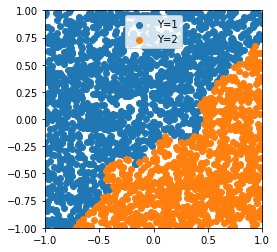

Vizualizing labelset:slice_1:pred from payload_train


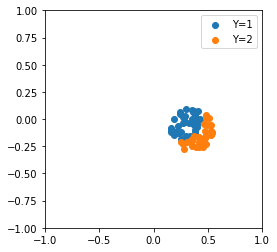

Vizualizing labelset:slice_2:pred from payload_train


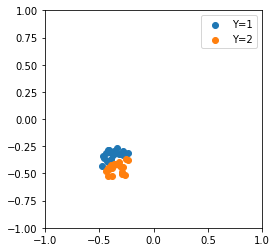

Vizualizing labelset:BASE:pred from payload_train


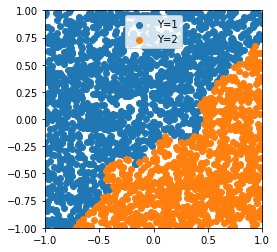

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_30/13_48_09/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.40e-01, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-01, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.45e-02, payload_valid/labelset:slice_1:pred/accuracy=8.48e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.00e-01, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=1.39e-01, train/all/lr=1.00e-02, valid/all/loss=7.96e-02]
[10.0 epo]: test_task:[payload_train/labelset_gold/loss=8.99e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.99e-02, payload_valid/labelset:BA

[75.0 epo]: test_task:[payload_train/labelset_gold/loss=8.92e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.98e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.80e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=8.80e-02, train/all/lr=1.00e-02, valid/all/loss=7.73e-02]
[80.0 epo]: test_task:[payload_train/labelset_gold/loss=8.92e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.98e-02, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/lo

[150.0 epo]: test_task:[payload_train/labelset_gold/loss=8.91e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.04e-02, payload_valid/labelset:slice_1:pred/accuracy=7.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.69e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=8.77e-02, train/all/lr=1.00e-02, valid/all/loss=7.68e-02]
[155.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.86e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.99e-02, payload_valid/labelset:slice_1:pred/accuracy=7.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[225.0 epo]: test_task:[payload_train/labelset_gold/loss=8.64e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.64e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.58e-02, payload_valid/labelset:slice_1:pred/accuracy=8.48e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.50e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=8.49e-02, train/all/lr=1.00e-02, valid/all/loss=7.01e-02]
[230.0 epo]: test_task:[payload_train/labelset_gold/loss=8.63e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.63e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.58e-02, payload_valid/labelset:slice_1:pred/accuracy=8.48e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[300.0 epo]: test_task:[payload_train/labelset_gold/loss=8.60e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.60e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.31e-02, payload_valid/labelset:slice_1:pred/accuracy=8.79e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.27e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=8.45e-02, train/all/lr=1.00e-02, valid/all/loss=6.97e-02]
[305.0 epo]: test_task:[payload_train/labelset_gold/loss=8.60e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.60e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.29e-02, payload_valid/labelset:slice_1:pred/accuracy=8.79e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[375.0 epo]: test_task:[payload_train/labelset_gold/loss=8.57e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.57e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.15e-02, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.24e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=8.42e-02, train/all/lr=1.00e-02, valid/all/loss=6.92e-02]
[380.0 epo]: test_task:[payload_train/labelset_gold/loss=8.57e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.57e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.13e-02, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[450.0 epo]: test_task:[payload_train/labelset_gold/loss=8.54e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.54e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.98e-02, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.23e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02, valid/all/loss=6.89e-02]
[455.0 epo]: test_task:[payload_train/labelset_gold/loss=8.54e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.54e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.95e-02, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Full model saved at /Users/vincentchen/code/metal/logs/2019_04_30/13_48_09/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9568, 'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9375, 'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.88, 'test_task:BASE:pred/payload_test/labelset:BASE:pred/accuracy': 0.9568}
==========Initializing + Training manual_reweighting==========
Creating 4 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=50.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_2:pred': '

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


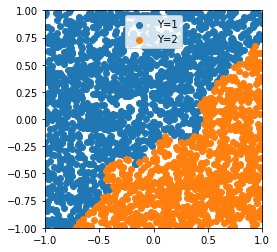

Vizualizing labelset:slice_1:pred from payload_train


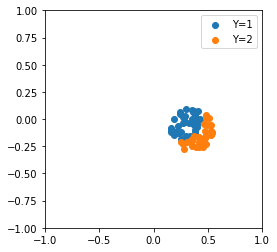

Vizualizing labelset:slice_2:pred from payload_train


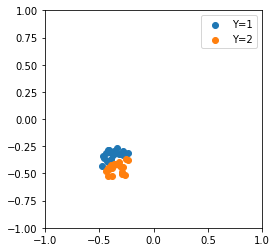

Vizualizing labelset:BASE:pred from payload_train


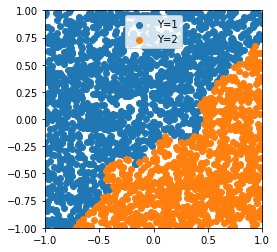

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_30/13_53_34/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.57e-01, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.57e-01, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.20e+01, payload_valid/labelset:slice_1:pred/accuracy=7.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.02e-01, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=4.76e-01, train/all/lr=1.00e-02, valid/all/loss=3.47e-01]
[10.0 epo]: test_task:[payload_train/labelset_gold/loss=9.76e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.76e-02, payload_valid/labelset:BA

[75.0 epo]: test_task:[payload_train/labelset_gold/loss=9.01e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=9.01e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.54e+01, payload_valid/labelset:slice_1:pred/accuracy=7.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=9.42e-02, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=3.11e-01, train/all/lr=1.00e-02, valid/all/loss=7.51e-01]
[80.0 epo]: test_task:[payload_train/labelset_gold/loss=8.96e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.96e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e+01, payload_valid/labelset:slice_1:pred/accuracy=7.58e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/lo

[150.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.38e+01, payload_valid/labelset:slice_1:pred/accuracy=7.88e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.91e-02, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=2.86e-01, train/all/lr=1.00e-02, valid/all/loss=9.12e-01]
[155.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.36e+01, payload_valid/labelset:slice_1:pred/accuracy=7.88e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[225.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.05e+01, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=2.38e-01, train/all/lr=1.00e-02, valid/all/loss=7.98e-01]
[230.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.04e+01, payload_valid/labelset:slice_1:pred/accuracy=8.18e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[300.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.80e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.07e+00, payload_valid/labelset:slice_1:pred/accuracy=8.48e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.51e-02, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=2.17e-01, train/all/lr=1.00e-02, valid/all/loss=7.45e-01]
[305.0 epo]: test_task:[payload_train/labelset_gold/loss=8.81e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=8.91e+00, payload_valid/labelset:slice_1:pred/accuracy=8.48e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[375.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.97e+00, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.34e-02, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.58e-01, train/all/lr=1.00e-02, valid/all/loss=6.95e-01]
[380.0 epo]: test_task:[payload_train/labelset_gold/loss=8.79e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.91e+00, payload_valid/labelset:slice_1:pred/accuracy=9.09e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

[450.0 epo]: test_task:[payload_train/labelset_gold/loss=8.81e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.45e+00, payload_valid/labelset:slice_1:pred/accuracy=9.39e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.91e-03, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=1.51e-01, train/all/lr=1.00e-02, valid/all/loss=6.56e-01]
[455.0 epo]: test_task:[payload_train/labelset_gold/loss=8.81e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.49e+00, payload_valid/labelset:slice_1:pred/accuracy=9.39e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=test)
Vizualizing labelset_gold from payload_train


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


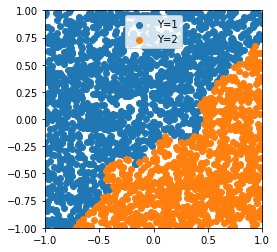

Creating 1 tasks...
BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)
[BinaryClassificationTask(name=expert:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)]
[Payload(payload_train: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=train), Payload(payload_valid: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=valid), Payload(payload_test: labels_to_tasks=[{'labelset:slice_1:pred': 'expert:slice_1:pred'}], split=test)]
No cuda device available. Using cpu instead.

Network architecture:
MetalModel(
  (input_modules): ModuleDict(
    (expert:slice_1:pred): Dat

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


[5.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.67e-01, payload_valid/labelset:slice_2:pred/accuracy=1.00e+00] model:[train/all/loss=6.67e-01, train/all/lr=1.00e-02, valid/all/loss=5.95e-01]
[10.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.37e-01, payload_valid/labelset:slice_2:pred/accuracy=1.00e+00] model:[train/all/loss=5.37e-01, train/all/lr=1.00e-02, valid/all/loss=3.85e-01]
[15.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.84e-01, payload_valid/labelset:slice_2:pred/accuracy=9.17e-01] model:[train/all/loss=3.84e-01, train/all/lr=1.00e-02, valid/all/loss=2.96e-01]
[20.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.56e-01, payload_valid/labelset:slice_2:pred/accuracy=8.33e-01] model:[train/all/loss=2.56e-01, train/all/lr=1.00e-02, valid/all/loss=2.85e-01]
[25.0 epo]: expert:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.68e-01, payload_valid/labelset:slice_2:pred/accur

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


[5.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.80e-01, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] model:[train/all/loss=1.80e-01, train/all/lr=1.00e-02, valid/all/loss=8.09e-02]
[10.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.99e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] model:[train/all/loss=8.99e-02, train/all/lr=1.00e-02, valid/all/loss=7.81e-02]
[15.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] model:[train/all/loss=8.93e-02, train/all/lr=1.00e-02, valid/all/loss=7.77e-02]
[20.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] model:[train/all/loss=8.92e-02, train/all/lr=1.00e-02, valid/all/loss=7.76e-02]
[25.0 epo]: expert:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] model:[train/all/loss=8.92e-02,

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


[5.0 epo]: test_task:[payload_train/labelset_gold/loss=8.61e-02, payload_valid/labelset_gold/accuracy=9.74e-01] model:[train/all/loss=8.61e-02, train/all/lr=1.00e-02, valid/all/loss=6.54e-02]
[10.0 epo]: test_task:[payload_train/labelset_gold/loss=6.94e-02, payload_valid/labelset_gold/accuracy=9.75e-01] model:[train/all/loss=6.94e-02, train/all/lr=1.00e-02, valid/all/loss=6.07e-02]
[15.0 epo]: test_task:[payload_train/labelset_gold/loss=6.49e-02, payload_valid/labelset_gold/accuracy=9.76e-01] model:[train/all/loss=6.49e-02, train/all/lr=1.00e-02, valid/all/loss=5.91e-02]
[20.0 epo]: test_task:[payload_train/labelset_gold/loss=6.27e-02, payload_valid/labelset_gold/accuracy=9.76e-01] model:[train/all/loss=6.27e-02, train/all/lr=1.00e-02, valid/all/loss=5.74e-02]
[25.0 epo]: test_task:[payload_train/labelset_gold/loss=6.06e-02, payload_valid/labelset_gold/accuracy=9.76e-01] model:[train/all/loss=6.06e-02, train/all/lr=1.00e-02, valid/all/loss=5.57e-02]
[30.0 epo]: test_task:[payload_train

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'test_task/payload_test/labelset_gold/accuracy': 0.9728}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_04_30/13_59_36/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_04_30/13_59_36/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_04_30/13_59_36/model.pkl
{'test_task/payload_test/labelset_gold/accuracy': 0.9728}
==========Initializing + Training naive==========
Creating 1 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=train)
Payload(payload_valid: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=valid)
Payload(payload_test: labels_to_tasks=[{'labelset_gold': 'test_task'}], split=test)
Vizualizing labelset_gold from payload_train


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


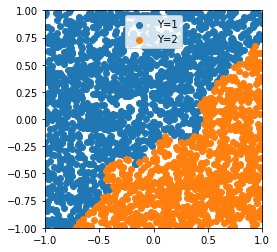

Beginning train loop.
Expecting a total of approximately 2512 examples and 157 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_30/14_00_24/config.json
[5.0 epo]: test_task:[payload_train/labelset_gold/loss=1.56e-01, payload_valid/labelset_gold/accuracy=9.66e-01] model:[train/all/loss=1.56e-01, train/all/lr=1.00e-02, valid/all/loss=8.09e-02]
[10.0 epo]: test_task:[payload_train/labelset_gold/loss=9.00e-02, payload_valid/labelset_gold/accuracy=9.67e-01] model:[train/all/loss=9.00e-02, train/all/lr=1.00e-02, valid/all/loss=7.81e-02]
[15.0 epo]: test_task:[payload_train/labelset_gold/loss=8.94e-02, payload_valid/labelset_gold/accuracy=9.68e-01] model:[train/all/loss=8.94e-02, train/all/lr=1.00e-02, valid/all/loss=7.77e-02]
[20.0 epo]: test_task:[payload_train/labelset_gold/loss=8.93e-02, payload_valid/labelset_gold/accuracy=9.68e-01] model:[train/all/loss=8.93e-02, train/all/lr=1.00e-02, valid/all/loss=7.76e-02]
[25.0 epo

[215.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.86e-02, train/all/lr=1.00e-02, valid/all/loss=7.70e-02]
[220.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.86e-02, train/all/lr=1.00e-02, valid/all/loss=7.70e-02]
[225.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.86e-02, train/all/lr=1.00e-02, valid/all/loss=7.70e-02]
[230.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.86e-02, train/all/lr=1.00e-02, valid/all/loss=7.70e-02]
[235.0 epo]: test_task:[payload_train/labelset_gold/loss=8.86e-02, payload_valid/labelset_gold/accuracy=9.69e-01] model:[train/all/loss=8.86e-02, train/all/lr=1.00e-02, valid/all/loss=7.70e-02]
[240.0 epo]: test_task:[payloa

[430.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.80e-02, train/all/lr=1.00e-02, valid/all/loss=7.43e-02]
[435.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.80e-02, train/all/lr=1.00e-02, valid/all/loss=7.42e-02]
[440.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.80e-02, train/all/lr=1.00e-02, valid/all/loss=7.42e-02]
[445.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.80e-02, train/all/lr=1.00e-02, valid/all/loss=7.42e-02]
[450.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.80e-02, train/all/lr=1.00e-02, valid/all/loss=7.41e-02]
[455.0 epo]: test_task:[payloa

/Users/vincentchen/code/metal/metal/mmtl/trainer.py:915: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


In [12]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
          
    tasks = create_tasks(
        task_name, 
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys, 
        batch_size=16, 
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for same total num epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': 'test_task:slice_1:ind',
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': 'test_task:slice_2:ind',
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9912,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.90625,
    'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9936,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.92}
Vizualizing test_task:slice_1:pred predictions

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


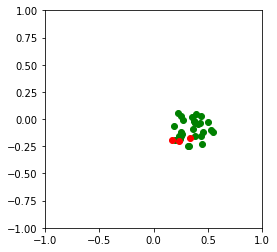

Vizualizing test_task:slice_1:ind predictions on labelset:slice_1:ind


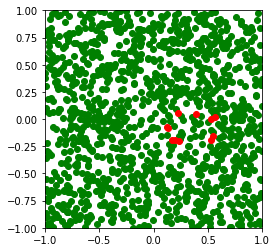

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


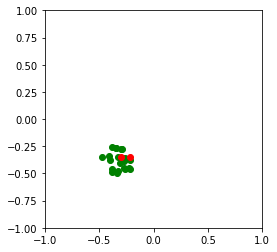

Vizualizing test_task:slice_2:ind predictions on labelset:slice_2:ind


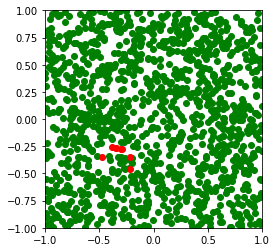

labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9375,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.88}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


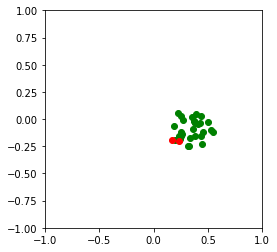

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


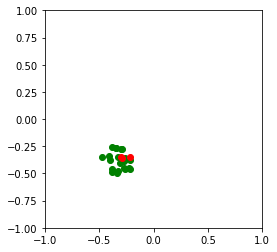

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9375,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.84}
Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


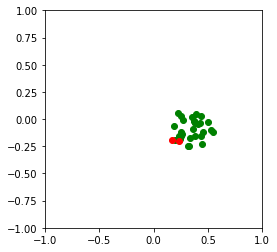

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


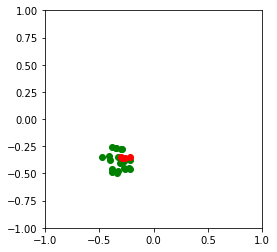

In [13]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks)
    if model_name in ["hard_param", "soft_param", "manual_reweighting"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9832355406538139,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.65625,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.88,
    'test_task/payload_test/labelset_gold/accuracy': 0.9728}
Vizualizing test_task predictions on labelset_gold


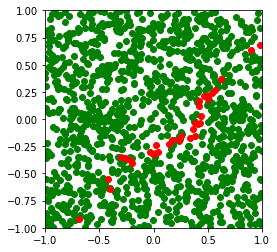

Vizualizing test_task predictions on labelset:slice_1:pred


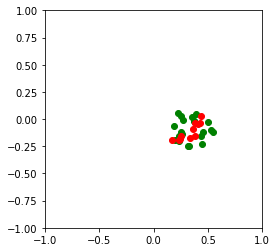

Vizualizing test_task predictions on labelset:slice_2:pred


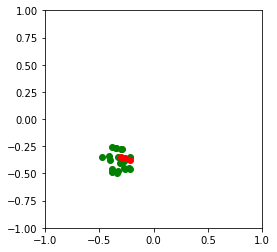

Vizualizing test_task predictions on labelset:remainder:pred


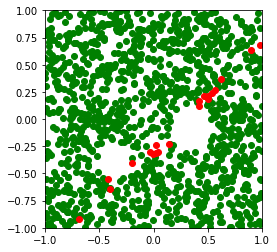

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9815590947191953,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.46875,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.4,
    'test_task/payload_test/labelset_gold/accuracy': 0.9568}
Vizualizing test_task predictions on labelset_gold


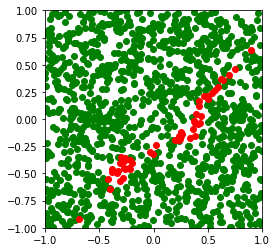

Vizualizing test_task predictions on labelset:slice_1:pred


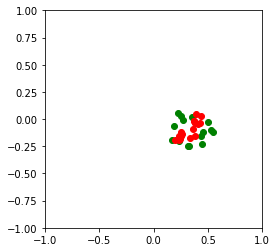

Vizualizing test_task predictions on labelset:slice_2:pred


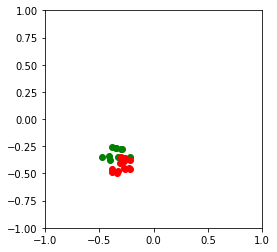

Vizualizing test_task predictions on labelset:remainder:pred


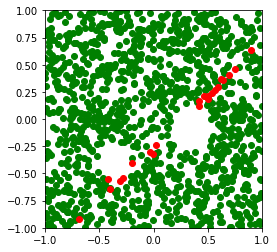

==========Evaluating manual_reweighting==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9823973176865046,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.4375,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.4,
    'test_task/payload_test/labelset_gold/accuracy': 0.9568}
Vizualizing test_task predictions on labelset_gold


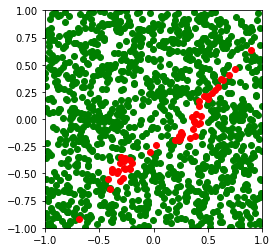

Vizualizing test_task predictions on labelset:slice_1:pred


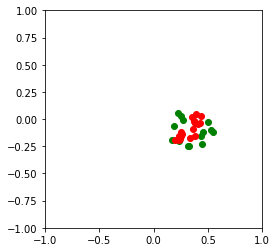

Vizualizing test_task predictions on labelset:slice_2:pred


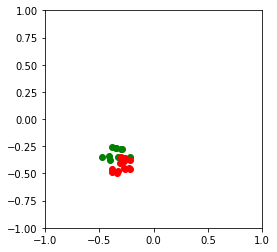

Vizualizing test_task predictions on labelset:remainder:pred


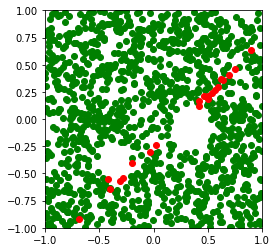

==========Evaluating moe==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.980720871751886,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.71875,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.92,
    'test_task/payload_test/labelset_gold/accuracy': 0.9728}
Vizualizing test_task predictions on labelset_gold


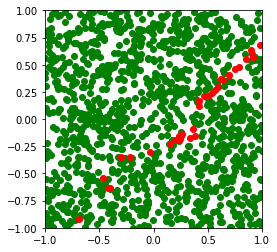

Vizualizing test_task predictions on labelset:slice_1:pred


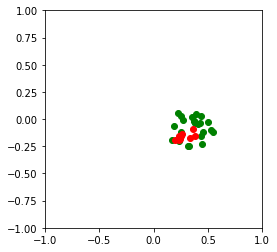

Vizualizing test_task predictions on labelset:slice_2:pred


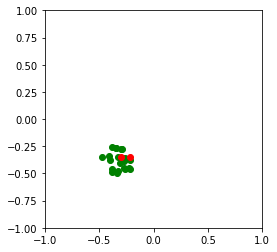

Vizualizing test_task predictions on labelset:remainder:pred


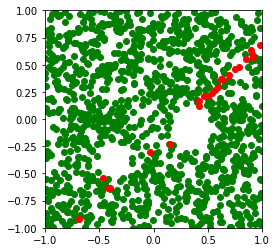

==========Evaluating naive==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9849119865884325,
    'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.4375,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.4,
    'test_task/payload_test/labelset_gold/accuracy': 0.9592}
Vizualizing test_task predictions on labelset_gold


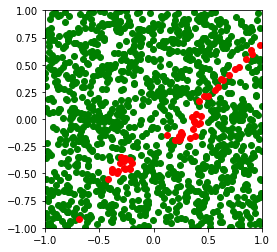

Vizualizing test_task predictions on labelset:slice_1:pred


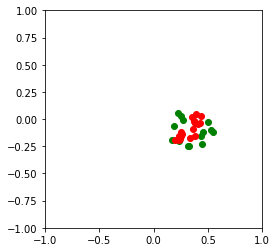

Vizualizing test_task predictions on labelset:slice_2:pred


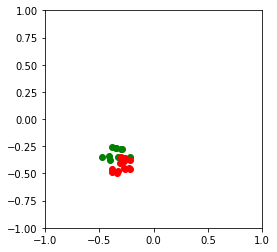

Vizualizing test_task predictions on labelset:remainder:pred


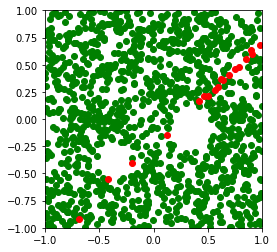

In [14]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task"
    }
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task).
Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


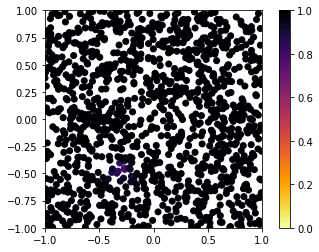

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


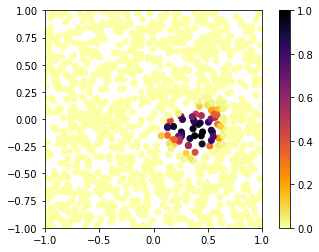

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


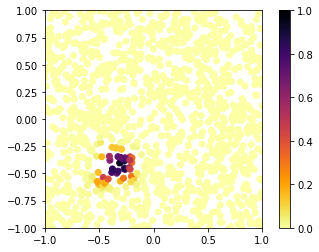

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


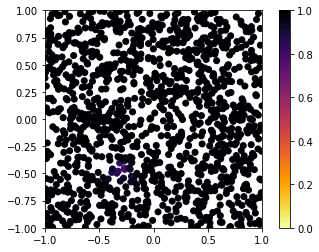

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


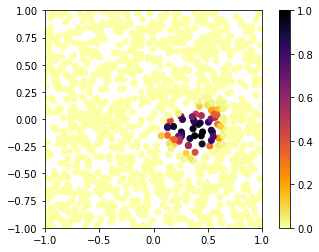

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


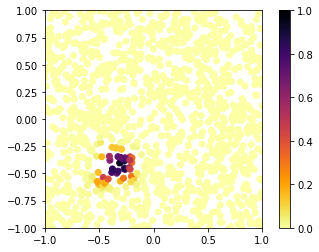

In [15]:
for model_name in trained_models.keys():
    if model_name != 'soft_param':
        continue

    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models['soft_param'], eval_payload)